In [70]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=1)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.2,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

# METHOD 1: Fit and transform separately (like sklearn.decomposition.PCA)
dyadic_sklearn.fit(X_demo)
coeffs_method1, leaf_indices_method1 = dyadic_sklearn.transform(X_demo)
X_recon_method1 = dyadic_sklearn.inverse_transform((coeffs_method1, leaf_indices_method1))

# Calculate reconstruction error
error_method1 = np.mean(np.linalg.norm(X_demo - X_recon_method1, axis=1))


DEBUG:root:Building tree at level 1, node indices: [1 7 2 0 4 8 5 3 6 9]
DEBUG:root:Updated tree height to 2
DEBUG:root:Processing internal node at level 1 with 9 children
DEBUG:root:Created child 1/9 at level 1
DEBUG:root:Building tree at level 2, node indices: [1]
DEBUG:root:Updated tree height to 3
DEBUG:root:Created leaf node at level 2 with indices: [1]
DEBUG:root:Created child 2/9 at level 1
DEBUG:root:Building tree at level 2, node indices: [7]
DEBUG:root:Created leaf node at level 2 with indices: [7]
DEBUG:root:Created child 3/9 at level 1
DEBUG:root:Building tree at level 2, node indices: [2]
DEBUG:root:Created leaf node at level 2 with indices: [2]
DEBUG:root:Created child 4/9 at level 1
DEBUG:root:Building tree at level 2, node indices: [0]
DEBUG:root:Created leaf node at level 2 with indices: [0]
DEBUG:root:Created child 5/9 at level 1
DEBUG:root:Building tree at level 2, node indices: [4 8]
DEBUG:root:Processing internal node at level 2 with 2 children
DEBUG:root:Created c

info: making wavelets


TypeError: _compute_return_shape() takes 1 positional argument but 2 were given


4. Visualizing first 10 examples: Original vs Reconstructed


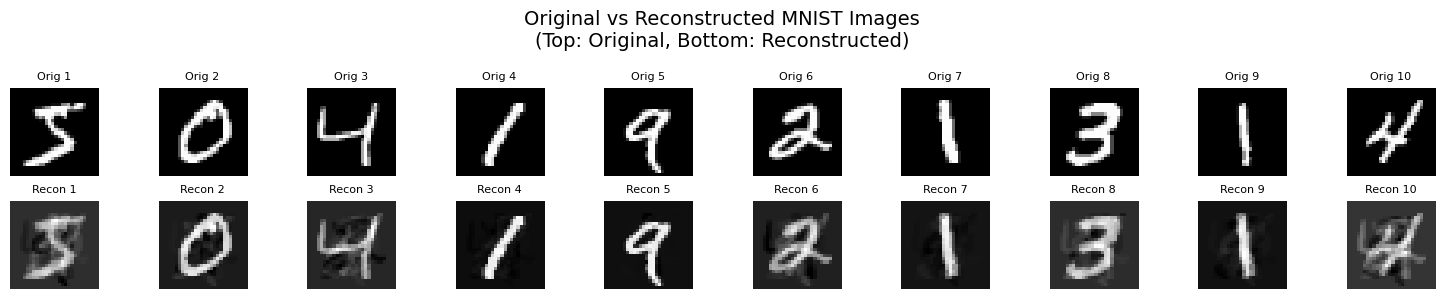

In [ ]:
# ========== VISUALIZATION: Original vs Reconstructed Images ==========
print("\n4. Visualizing first 10 examples: Original vs Reconstructed")

# Reshape data back to image format (28x28 for MNIST)
X_demo_images = X_demo[:10].reshape(-1, 28, 28)
X_recon_images = X_recon_method1[:10].reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original vs Reconstructed MNIST Images\n(Top: Original, Bottom: Reconstructed)', fontsize=14)

# Display original images in first row
for i in range(10):
    axes[0, i].imshow(X_demo_images[i], cmap='gray')
    axes[0, i].set_title(f'Orig {i+1}', fontsize=8)
    axes[0, i].axis('off')

# Display reconstructed images in second row
for i in range(10):
    axes[1, i].imshow(X_recon_images[i], cmap='gray')
    axes[1, i].set_title(f'Recon {i+1}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

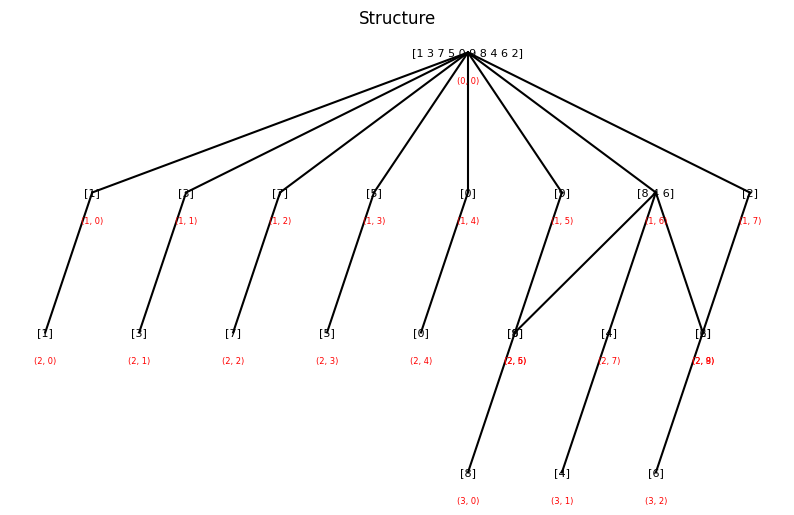

In [ ]:
dyadic_sklearn.plot_tree()

In [ ]:
# dyadic_sklearn.grow_tree()

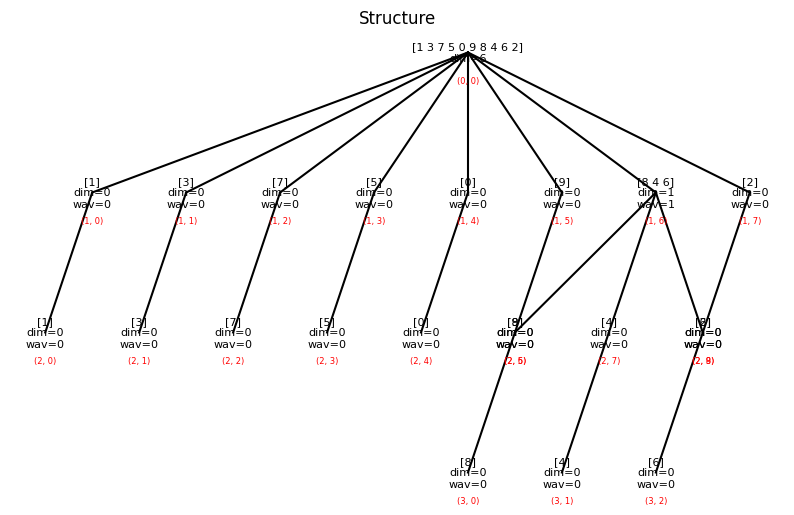

In [ ]:
dyadic_sklearn.plot_tree(show_basis_dim=True)

In [ ]:
dyadic_sklearn.root.basis.shape

(6, 784)

In [ ]:
coeffs_method1[0]


[array([[-3.3968937 ],
        [ 2.8215175 ],
        [-2.7716575 ],
        [ 0.76894903],
        [ 1.1593666 ],
        [-2.2342982 ]], dtype=float32),
 array([], shape=(0, 1), dtype=float64),
 array([], shape=(0, 1), dtype=float64)]

In [ ]:
# dyadic_sklearn.fgwt(X_demo[8].reshape(1, -1))

In [ ]:
dummy = dyadic_sklearn.fgwt_all_node(X_demo)

DEBUG:root:Starting forward GMRA wavelet transform for all nodes
DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 10 leaf nodes
DEBUG:root:Total leaf nodes: 10
DEBUG:root:Leaf node (j=2, k=0) with idxs: [1]
DEBUG:root:Leaf node (j=2, k=1) with idxs: [3]
DEBUG:root:Leaf node (j=2, k=2) with idxs: [7]
DEBUG:root:Leaf node (j=2, k=3) with idxs: [5]
DEBUG:root:Leaf node (j=2, k=4) with idxs: [0]
DEBUG:root:Leaf node (j=2, k=5) with idxs: [9]
DEBUG:root:Leaf node (j=3, k=0) with idxs: [8]
DEBUG:root:Leaf node (j=3, k=1) with idxs: [4]
DEBUG:root:Leaf node (j=3, k=2) with idxs: [6]
DEBUG:root:Leaf node (j=2, k=9) with idxs: [2]
DEBUG:root:Processing leaf 1/10, leaf at (j=2, k=0)
DEBUG:root:Leaf 0: path length 3, leaf->root traversal
DEBUG:root:Leaf 0: processed node at (j=1, k=0), qjx shape: (0, 1)
DEBUG:root:Leaf 0: completed, total coefficients at 3 levels
DEBUG:root:Leaf 1: path length 3, leaf->root traversal
DEBUG:root:Leaf 1: processed node at (j=1, k=1), qjx sh

In [ ]:
dummy, coeff_map = dyadic_sklearn.fgwt_all_node(X_demo)

DEBUG:root:Starting forward GMRA wavelet transform for all nodes
DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 10 leaf nodes
DEBUG:root:Total leaf nodes: 10
DEBUG:root:Leaf node (j=2, k=0) with idxs: [1]
DEBUG:root:Leaf node (j=2, k=1) with idxs: [3]
DEBUG:root:Leaf node (j=2, k=2) with idxs: [7]
DEBUG:root:Leaf node (j=2, k=3) with idxs: [5]
DEBUG:root:Leaf node (j=2, k=4) with idxs: [0]
DEBUG:root:Leaf node (j=2, k=5) with idxs: [9]
DEBUG:root:Leaf node (j=3, k=0) with idxs: [8]
DEBUG:root:Leaf node (j=3, k=1) with idxs: [4]
DEBUG:root:Leaf node (j=3, k=2) with idxs: [6]
DEBUG:root:Leaf node (j=2, k=9) with idxs: [2]
DEBUG:root:Processing leaf 1/10, leaf at (j=2, k=0)
DEBUG:root:Leaf 0: path length 3, leaf->root traversal
DEBUG:root:Leaf 0: processed node at (j=1, k=0), qjx shape: (0, 1)
DEBUG:root:Leaf 0: completed, total coefficients at 3 levels
DEBUG:root:Leaf 1: path length 3, leaf->root traversal
DEBUG:root:Leaf 1: processed node at (j=1, k=1), qjx sh

In [ ]:
coeff_map

{(2, 0): array([], shape=(0, 1), dtype=float64),
 (1, 0): array([], shape=(0, 1), dtype=float64),
 (0,
  0): array([[ 1.22152603],
        [-4.83871603],
        [-2.62412906],
        [-2.98500037],
        [ 0.50078928],
        [ 1.32563651]]),
 (2, 1): array([], shape=(0, 1), dtype=float64),
 (1, 1): array([], shape=(0, 1), dtype=float64),
 (2, 2): array([], shape=(0, 1), dtype=float64),
 (1, 2): array([], shape=(0, 1), dtype=float64),
 (2, 3): array([], shape=(0, 1), dtype=float64),
 (1, 3): array([], shape=(0, 1), dtype=float64),
 (2, 4): array([], shape=(0, 1), dtype=float64),
 (1, 4): array([], shape=(0, 1), dtype=float64),
 (2, 5): array([], shape=(0, 1), dtype=float64),
 (1, 5): array([], shape=(0, 1), dtype=float64),
 (3, 0): array([], shape=(0, 1), dtype=float64),
 (2, 6): array([], shape=(0, 1), dtype=float64),
 (1, 6): array([[-1.85133985]]),
 (3, 1): array([], shape=(0, 1), dtype=float64),
 (2, 7): array([], shape=(0, 1), dtype=float64),
 (3, 2): array([], shape=(0, 1), 

In [ ]:
dyadic_sklearn.fgwt(X_demo[9].reshape(1, -1))

DEBUG:root:Starting forward GMRA wavelet transform for 1 data points
DEBUG:root:Found 1 leaf nodes, levels range: j=2 to j=2
DEBUG:root:Processing point 1/1, leaf at (j=2, k=9)
DEBUG:root:Point 0: path length 3, leaf->root traversal
DEBUG:root:Point 0: processed node at (j=1, k=7), qjx shape: (0, 1)
DEBUG:root:Point 0: completed, total coefficients at 3 levels
DEBUG:root:Forward GMRA wavelet transform completed


([[array([[-1.1868395 ],
          [ 3.5621932 ],
          [ 0.1697363 ],
          [-0.85776764],
          [ 0.42067093],
          [ 2.9086134 ]], dtype=float32),
   array([], shape=(0, 1), dtype=float64),
   array([], shape=(0, 1), dtype=float64)]],
 [(2, 9)])